In [1]:
import cv2 
from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes

from spatial_statistics_tools import *
from process_images import *
from utilities import *
from pylab import figure, cm
from matplotlib.colors import LogNorm
#from skimage import feature, restoration, segmentation, exposure, img_as_float
#from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes
#from skimage.filters import gaussian
#from datetime import datetime

In [18]:
masks = {
    "cell" : np.load("toy_data_imgs/cell.npy"),
    "circle" : np.load("toy_data_imgs/circle.npy"),
    "square" : np.load("toy_data_imgs/square.npy"),
    "triangle1" : np.load("toy_data_imgs/triangle1.npy"),
    "triangle2" : np.load("toy_data_imgs/triangle2.npy"),
    "triangle3" : np.load("toy_data_imgs/triangle3.npy"),
    "triangle4" : np.load("toy_data_imgs/triangle4.npy"),
}

custom_patterns = {
    "double_cluster" : np.load("toy_data_imgs/clustered.npy"),
    "two_dots" : np.load("toy_data_imgs/two_dots.npy"),
    "disperse" : np.load("toy_data_imgs/dispersed.npy"),
}

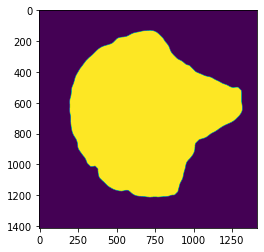

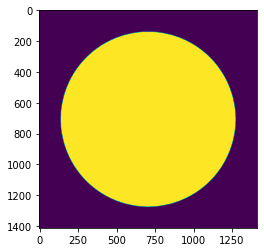

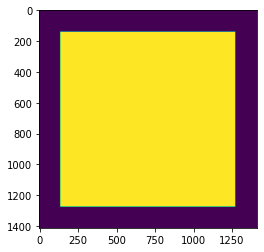

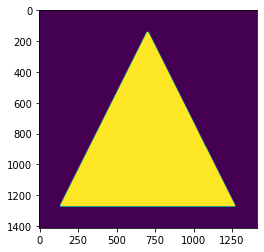

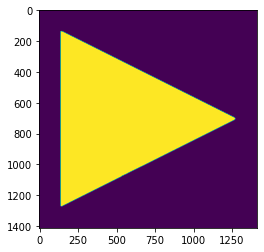

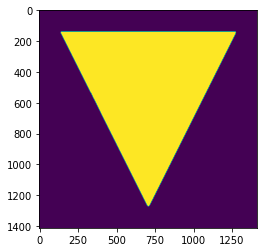

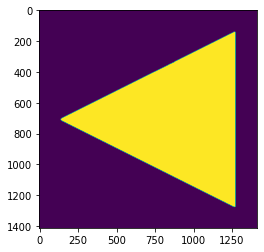

In [19]:
for k in masks.keys():
    plt.imshow(masks[k])
    plt.show()

In [56]:
def truncated_gaussian(mean, sigma, N=1):
    """
    ...
    """
    return np.round(np.random.normal(mean, sigma, N))


def generate_random_cell_image(mask, point_radius=8, pixel_int=10, n_points=1000, n_points_cluster=0, cluster_size=100, cluster_positions=[(0,0)], desired_int=2000000000, binary=False, seed=None):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)
    
    if n_points_cluster > n_points:
        print("Error! Total number of pixels n_points must be larger than or equal to n_points_cluster!")
        return

    n_points_uniform = n_points - n_points_cluster

    # define size of cluster := FWHM = 2.355 * sigma (for Gaussian)
    sigma = cluster_size/2.355
    n_points_cluster = int(n_points_cluster/len(cluster_positions))

    # set seed
    np.random.seed(seed)

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_points_uniform:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
            arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]
            count+=1

    # generate additional pixels around a defined cluster 
    for cluster_pos in cluster_positions:
        mean_x, mean_y = cluster_pos
        count=0
        while count<n_points_cluster:
            rnd_x = int(truncated_gaussian(mean_x+x_lim/2, sigma))
            rnd_y = int(truncated_gaussian(mean_y+y_lim/2, sigma))
            if (rnd_x < x_lim) and (rnd_y < y_lim):
                if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
                    arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]    
                    count+=1

    if np.sum(arr) != pixel_int*n_points:
        print("Error! Amount of points in resulting image is not equal to specified number of points!")
        return

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=point_radius-4)
    arr = gaussian(arr, sigma=3)
    
    # if binary, then image will only have values 1 or 0
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97

    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    np.random.seed(None)
    
    return img_real, img_csr


def generate_equally_spaced_image(mask, point_radius, pixel_int, spacing, desired_int):
    """
    Within a shape specified by mask, generate equally spaced grid.
    """
    arr = np.zeros(mask.shape)

    for i in range(1, int(arr.shape[0]/spacing)):
        for j in range(1, int(arr.shape[1]/spacing)):
            x = i*spacing
            y = j*spacing + int(spacing/2 * (i%2))

            if mask[x,y] == 1:
                arr[x,y] = 10

    arr = binary_dilation(arr, iterations=point_radius-4)
    arr = gaussian(arr, sigma=3)
    
    img_real = scale_image(arr, desired_int)
    img_csr = scale_image(mask, desired_int)

    return img_real, img_csr


def get_K_data(mask, img_real, img_csr, range_of_t, width, printout=True):
    """
    ...
    """
    K_values_real, K_values_ring_real, corr_real = ripleys_K_fast_ring(img_real, mask, range_of_t, width, printout)
    K_values_csr, K_values_ring_csr, corr_csr = ripleys_K_fast_ring(img_csr, mask, range_of_t, width, printout)    
    data_real = [np.array(K_values_real), np.array(K_values_ring_real), corr_real, range_of_t]
    data_csr = [np.array(K_values_csr), np.array(K_values_ring_csr), corr_csr, range_of_t]
    
    return data_real, data_csr

In [57]:
def plot_results1(data_real, data_csr, width, title="", path="./unnamed.pdf", show=False, save=True):
    
    
    K_values_real, K_values_ring_real, corr_real, range_of_t = data_real
    K_values_csr, K_values_ring_csr, corr_csr, range_of_t = data_csr
    
    K_diff = K_values_real - K_values_csr
    K_ring_diff = K_values_ring_real - K_values_ring_csr


    # works only if number odd, but this should be given for autocorrelation
    len_ = corr_real.shape[0]
    lim_lower = -int(len_/2)
    lim_upper = int(len_/2)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0][0].imshow(img_real)
    im1 = ax[0][0].imshow(img_real)
    ax[0][0].set_title("Original (\"real\") image")
    ax[0][1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
    im2 = ax[0][1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper])    
    ax[1][0].set_title("Autocorr. real image")

    ax[1][0].set_title("K function for (real)-(CSR)")
    ax[1][0].plot(range_of_t, K_diff)
    ax[1][0].set_xlabel("$t$")
    ax[1][0].set_ylabel("$K(t)$")
    ax[1][0].set_ylim(top=210000)

    ax[1][1].set_title(f"Ring K function for (real)-(CSR), width={width}")
    ax[1][1].plot(range_of_t + int(width/2), K_ring_diff)
    ax[1][1].set_xlabel("$t$")
    ax[1][1].set_ylabel("$K_{Ring}(t)$")
    ax[1][1].set_ylim(top=800, bottom=-800)

    plt.colorbar(im1, ax=ax[0, 0])
    plt.colorbar(im2, ax=ax[0, 1])

    fig.suptitle(title)
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    plt.close()
    
    
    
def plot_results2(data_real, data_csr, width, title="", path="./unnamed.pdf", show=False, save=True):

    
    K_values_real, K_values_ring_real, corr_real, range_of_t = data_real
    K_values_csr, K_values_ring_csr, corr_csr, range_of_t = data_csr

    K_diff = K_values_real - K_values_csr
    K_ring_diff = K_values_ring_real - K_values_ring_csr

    # works only if number odd, but this should be given for autocorrelation
    len_ = corr_real.shape[0]
    lim_lower = -int(len_/2)
    lim_upper = int(len_/2)

    fig, ax = plt.subplots(1, 4, figsize=(30, 6))

    ax[0].imshow(img_real)
    im1 = ax[0].imshow(img_real)
    ax[0].set_title("Original (\"real\") image")
    ax[1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
    im2 = ax[1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper])    

    ax[2].set_title(f"Ring K functions for real and CSR image")
    ax[2].plot(range_of_t + int(width/2), K_values_ring_real, label="Real image")
    ax[2].plot(range_of_t + int(width/2), K_values_ring_csr, label="CSR image")
    ax[2].plot(range_of_t + int(width/2), K_ring_diff, label="Difference")
    ax[2].legend(loc='upper right')
    ax[2].set_xlabel("$t$")
    ax[2].set_ylabel("$Autocorr$")
    #ax[2].set_ylim(top=20)

    ax[3].set_title(f"Ring K function for (real)-(CSR), width={width}")
    ax[3].plot(range_of_t + int(width/2), K_ring_diff)
    ax[3].set_xlabel("$t$")
    ax[3].set_ylabel("$K_{Ring}(t)$")

    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])

    fig.suptitle(title)
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    plt.close()

Creating ...
Completed in 12.43 seconds
Completed in 12.81 seconds


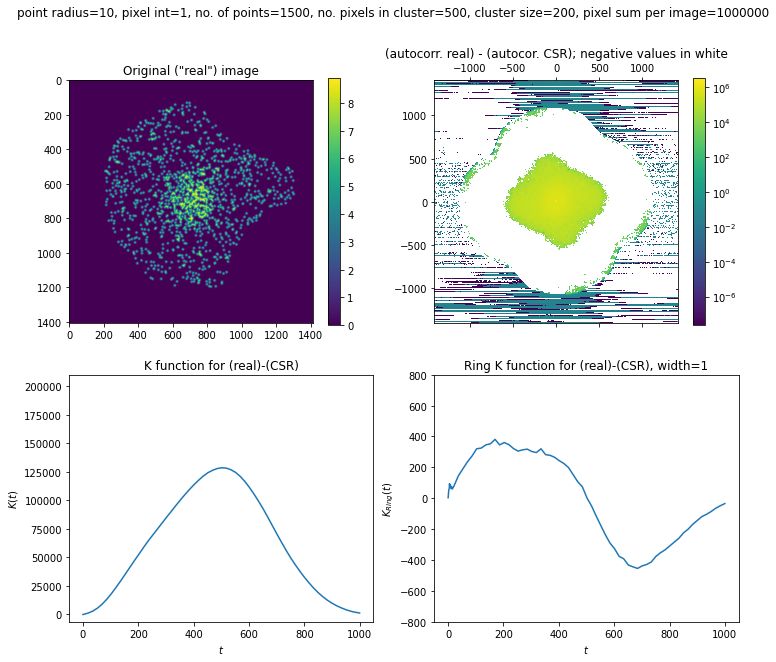

Completed!


In [58]:
# for "ring" K function
width=1
point_radius=10
pixel_int=1
n_points=1500
# in case of equally-spaced grid
spacing=40
n_points_cluster=500
cluster_size=200
#cluster_positions=[(250,0),(-250,0),(0,200),(0,-200)]
cluster_positions = [(0,0)]
desired_int=1000000
binary=False
rnd_overlay = 0
true_csr = False

show = True
save = False

custom_pattern_name = "double_cluster"
mask_name = "cell"
mode = "normal"

seed=65493

range_of_t = np.array(list(range(20)) + list(np.linspace(20, 1000, 60)))
#range_of_t = np.linspace(0, 1200, 121)

#range_of_t = np.linspace(10, 1200, 11)


folder = "toy_data_results"

    #for i in range(0,1):
    #for n_points in [2000, 1000, 500, 100]:
    #for mode in ['cell', 'equally_spaced']:



        #for point_radius, spacing in [[10, 40]]:



        
#for cluster_size in [500, 300, 200, 100]:
#for mask_name in list(masks.keys()):
#for i in range(5):
#for angle in [0,90,180,270]:

# cluster_pos=(-200+40*i,+200-40*i)
# n_total = 2000 - 400*i
#n_points = int(n_total * 0.7)
#n_points_cluster = int(n_total * 0.3)
#cluster_positions=[(200+i*15,0),(-200-i*15,0),(0,200),(0,-200)]
#width = 1+i
custom_pattern = custom_patterns[custom_pattern_name]
mask = masks[mask_name]
csr_name = "true_random_csr" if true_csr else "averaged_csr"


#filename = f"cluster_size{cluster_size}_.pdf"
filename = ""#f"#{i}different_total_point_number.pdf"
#filename = f"new_plot_{mask_name}.pdf"

path = os.path.join(folder, filename)
print(f"Creating {filename}...")

if mode=='equally_spaced':
    title = f"point radius={point_radius}, pixel int={pixel_int}, grid spacing={spacing}, pixel sum per image={desired_int}"
    img_real, img_csr = generate_equally_spaced_image(mask, point_radius, pixel_int, spacing, desired_int)
elif mode=='custom':
    title = f"{custom_pattern_name.replace('_', '')}, pixel sum per image={desired_int}"
    rnd_points = generate_random_cell_image(mask, point_radius, pixel_int, n_points, n_points_cluster=0, cluster_size=0, cluster_positions=[(0,0)], desired_int=desired_int, binary=False, seed=seed)[0] 
    custom_pattern = scale_image(custom_pattern, desired_int)
    img_real = scale_image(custom_pattern + rnd_overlay*rnd_points, desired_int)
    img_csr = scale_image(mask, desired_int)
else:
    title = f"point radius={point_radius}, pixel int={pixel_int}, no. of points={n_points}, no. pixels in cluster={n_points_cluster}, cluster size={cluster_size}, pixel sum per image={desired_int}"
    img_real, img_csr = generate_random_cell_image(mask, point_radius, pixel_int, n_points, n_points_cluster, cluster_size, cluster_positions, desired_int, False, seed) 

#  img_real = rotate_image(img_)


# generate CSR with actual uniformely random pixel distribution
if true_csr:
    img_csr = create_csr_img(mask, desired_int)

data_real, data_csr = get_K_data(mask, img_real, img_csr, range_of_t, width, True)

plot_results1(data_real, data_csr, width, title, path, show, save)

        
print("Completed!")

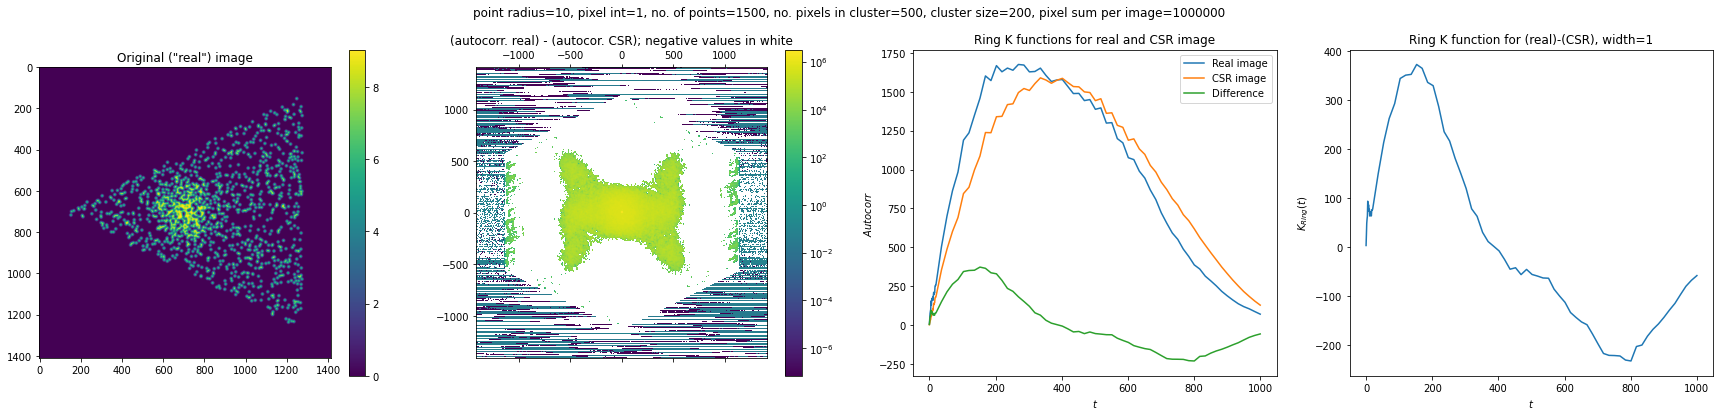

In [149]:
plot_results2(data_real, data_csr, width, title, path, True, False)

In [52]:
img = custom_patterns["double_cluster"]


mask = masks["circle"]

img = scale_image(img, 1000000)
csr = scale_image(mask, 1000000)


corr_real = signal.correlate(img, img)


range_of_t = np.linspace(5, 600, 60)
Ks = ripleys_K_fast(img, mask, range_of_t, True)
#Ks_csr = ripleys_K_fast(csr, mask, range_of_t, True)


# works only if number odd, but this should be given for autocorrelation
len_ = corr_real.shape[0]
lim_lower = -int(len_/2)
lim_upper = int(len_/2)


Completed in 4.17 seconds


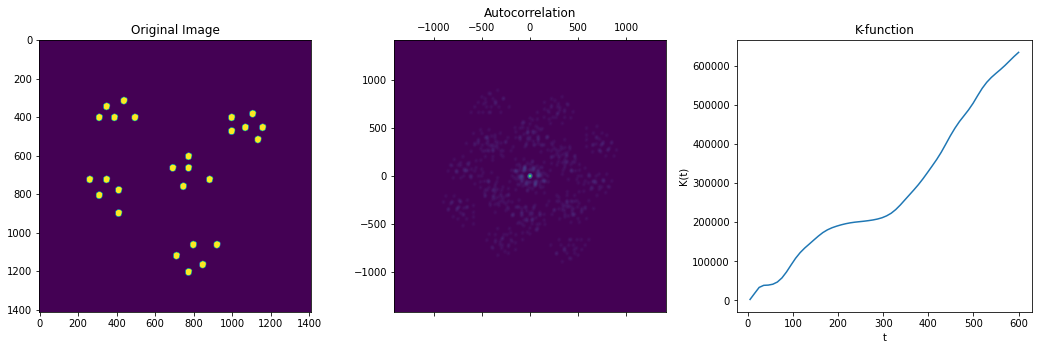

In [53]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].matshow((corr_real), extent=[lim_lower, lim_upper, lim_lower, lim_upper])  
ax[1].set_title("Autocorrelation")
ax[2].plot(range_of_t, Ks)
ax[2].set_ylabel("K(t)")
ax[2].set_xlabel("t")
ax[2].set_title("K-function")
plt.savefig("K_function_example.pdf")

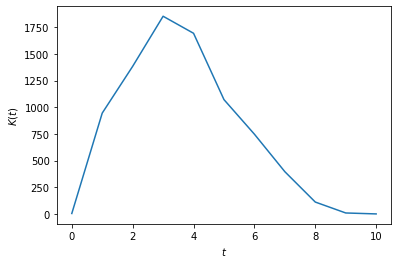

In [140]:
plt.plot(K_values_ring_real/1)
plt.xlabel("$t$")
plt.ylabel("$K(t)$")

filename = f"test_K.pdf"
path = os.path.join(folder, filename)
plt.savefig(path)

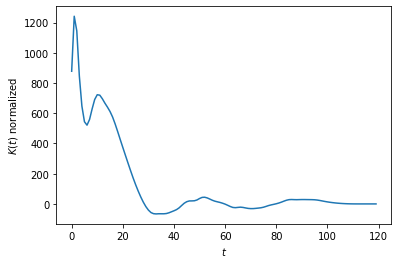

In [37]:
x = 1
plt.plot(K_diff[x:]/range_of_t[x:])
#plt.ylim(top=20)
plt.xlabel("$t$")
plt.ylabel("$K(t)$ normalized")

filename = f"test_K_norm2.pdf"
path = os.path.join(folder, filename)
plt.savefig(path)

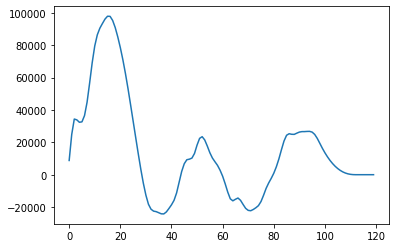

In [17]:
plt.plot(K_diff[1:])

In [37]:
rnd_points = generate_random_cell_image(mask, point_radius, pixel_int, n_points, n_points_cluster=0, cluster_size=0, cluster_positions=[(0,0)], desired_int=desired_int, binary=False, seed=seed) 

print(rnd_points)

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))


-----
### Testing interpretability

In [683]:
def create_ellipsis(N, dimx=512, ratio=1, x_shift=0, y_shift=0, N_missing=0, N_holes=0, intensity=1, is_hole=False):
    """
    Creates dimx by dimx array of zeros with an ellipse of ones. The ellipse can have a specified number of holes.
    
    Args:
        bool is_hole: ...
        ...
    """

    if N_missing>0 and N_holes>0:
        N_tot = N + N_missing
    else:
        N_tot = N

    # number pixels is equal to area N = np.pi * a * b
    # N = np.pi * a**2 * ratio 
    a = np.sqrt(N_tot / (np.pi * ratio))
    b = ratio * a

    half_dim = int((dimx)/2)

    x_range = list(abs(np.arange(-half_dim-x_shift, half_dim-x_shift)))
    y_range = list(abs(np.arange(-half_dim-y_shift, half_dim-y_shift)))

    # array where every element is x distance from center
    diff_x = np.array([x_range, ]*dimx)

    # array where every element is y distance from center
    diff_y = np.array([y_range, ]*dimx).T

    diff_xy = np.sqrt((diff_x/a)**2 + (diff_y/b)**2)

    out_array = np.zeros((dimx, dimx))
    out_array[diff_xy<=1] = 1
        
    if N_missing>0 and N_holes>0:
        
        missing_per_hole = int(N_missing/N_holes)
        
        for i in range(N_holes):
            
            old_out = np.array([-1])
            
            # counting iterations to avoid infinite loop
            count = 0
            max_iter = 30
    
            while -1 in old_out:
            
                count +=1
                if count > max_iter:
                    raise Exception("Too many iterations! Could not place holes successfully. Try reducing number of holes or number of pixels in holes.")
                            
                old_out = out_array.copy()

                x_pos = np.random.randint(low=-int(a), high=int(a), size=1)[0]
                y_pos = np.random.randint(low=-int(b), high=int(b), size=1)[0]
                
                hole = create_ellipsis(N=missing_per_hole, dimx=dimx, x_shift=x_shift+x_pos, y_shift=y_shift+y_pos, N_missing=0, intensity=1, is_hole=True)

                old_out = old_out - hole
            
            # overwrite using the new version with hole
            out_array = old_out    

    if not is_hole:
        actual_number = np.sum(out_array)
        wanted_number = N 
        number_deviation = abs(wanted_number - actual_number) / wanted_number

        if number_deviation > 0.005:
            print(f"Actual number: {actual_number}; wanted number: {wanted_number}; deviation: {number_deviation}")
            raise Exception("Number of actual pixels in ellipse is much lower than the desired number!")
  
    out_array = out_array * intensity
    return out_array
    
    
    
def create_csr_img(mask, desired_int):
    """
    Generates uniformely random pixel intensities in a shape specified by mask.
    """
    rnd_array = np.random.random(size=mask.shape)
    csr_img = rnd_array * mask
    csr_img *= desired_int/np.sum(csr_img)
    return csr_img   

(1412, 1412)


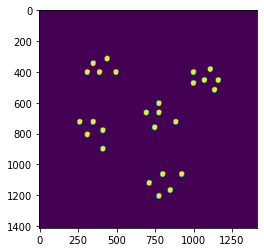

In [748]:
cluster_new = np.pad(cluster, 37)
cluster_new = scale_image(cluster_new, 1000)
print(cluster_new.shape)
plt.imshow(cluster_new)

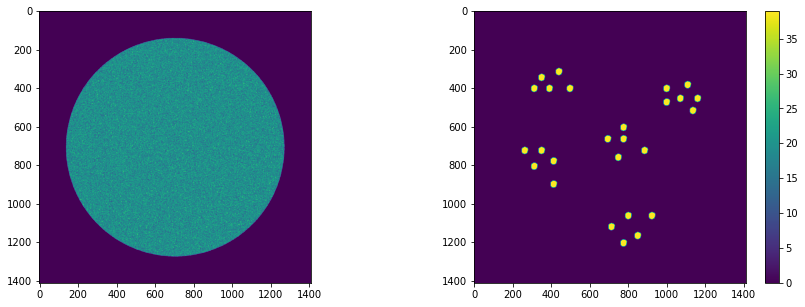

In [751]:
radius = 50
shift = 200
N = radius**2 * np.pi

#small_circle = create_ellipsis(N, dimx=circle.shape[0], x_shift=shift) + create_ellipsis(N, dimx=circle.shape[0], x_shift=-shift)
#gaussian(create_ellipsis(N, dimx=circle.shape[0]), sigma=50)

#small_circle = create_ellipsis(N, dimx=circle.shape[0], x_shift=shift)




desired_int = 1000000
temp_real = scale_image(cluster_new, desired_int)
temp_csr = create_csr_img(circle, desired_int)

img_real = scale_image(temp_real + 0* temp_csr, desired_int)
img_csr = scale_image(temp_csr, desired_int)


fig, ax = plt.subplots(1,2, figsize=(15,5))
im_ = ax[1].imshow(img_real)
ax[0].imshow(img_csr)

plt.colorbar(im_, ax=ax[1])
plt.show()

In [752]:
#print(np.mean(img_real[650:750,650:750])/np.mean(img_real[600:800,1000:1100]))

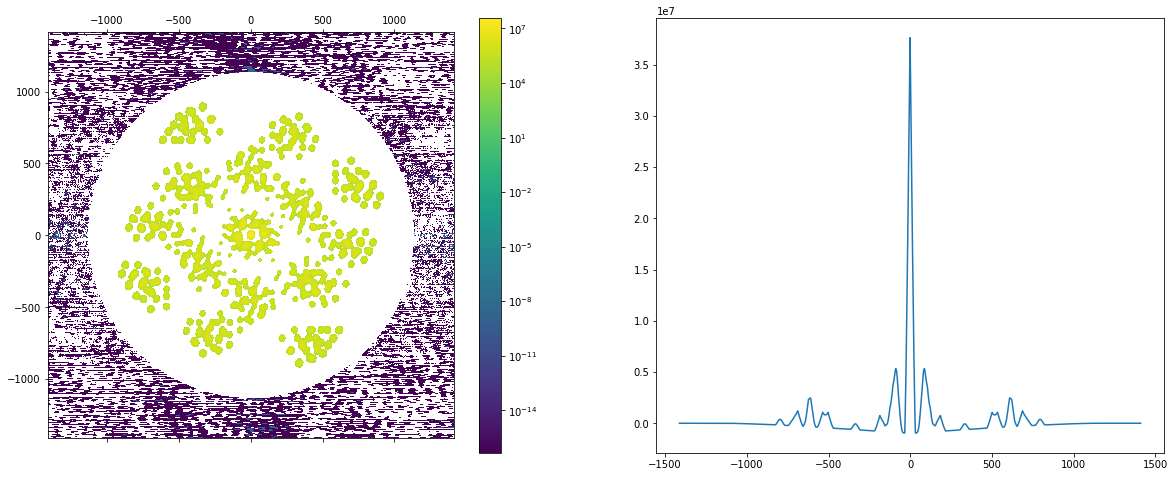

In [753]:
real_corr = signal.correlate(img_real, img_real)
csr_corr = signal.correlate(img_csr, img_csr)
diff_corr = real_corr - csr_corr

fig, ax = plt.subplots(1,2,figsize=(20,8))
im = ax[0].matshow(diff_corr, norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper])
#ax[1].plot(np.linspace(-1411, 1411, 2823)-1, real_corr[1411, :])
#ax[1].plot(np.linspace(-1411, 1411, 2823)-1, csr_corr[1411, :])
ax[1].plot(np.linspace(-1411, 1411, 2823)-1, diff_corr[1411, :])
plt.colorbar(im, ax=ax[0])
plt.show()

In [759]:
range_of_t = np.linspace(0,1000, 1001)
_, K_real, _ = ripleys_K_fast_ring(img_real, mask, range_of_t, width=20, printout=True)
_, K_csr, _ = ripleys_K_fast_ring(img_csr, mask, range_of_t, width=20, printout=True)
K_diff = np.array(K_real)-np.array(K_csr)

Completed in 135.39 seconds
Completed in 131.46 seconds


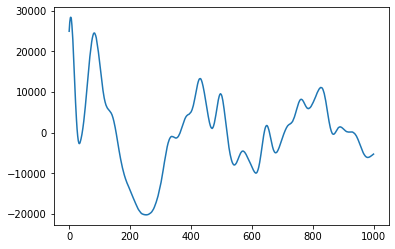

In [761]:
K = K_diff
plt.plot(range_of_t, K)
#plt.vlines(x=radius*2, ymin=np.min(K), ymax=np.max(K), linestyle='dashed', color='red')
#plt.vlines(x=shift*2, ymin=np.min(K), ymax=np.max(K), linestyle='dashed', color='green')
plt.show()

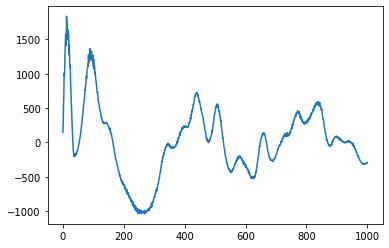

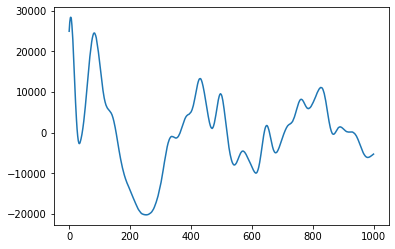

In [760]:
K = K_diff
plt.plot(range_of_t, K)
#plt.vlines(x=radius*2, ymin=np.min(K), ymax=np.max(K), linestyle='dashed', color='red')
#plt.vlines(x=shift*2, ymin=np.min(K), ymax=np.max(K), linestyle='dashed', color='green')
plt.show()

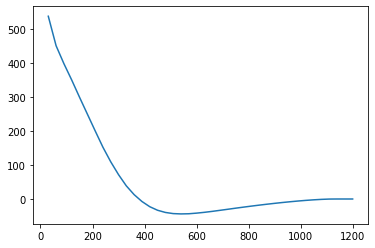

In [430]:
#range_of_t 

plt.plot(range_of_t[4:], K_ring_diff[1:]/(range_of_t[1:]))

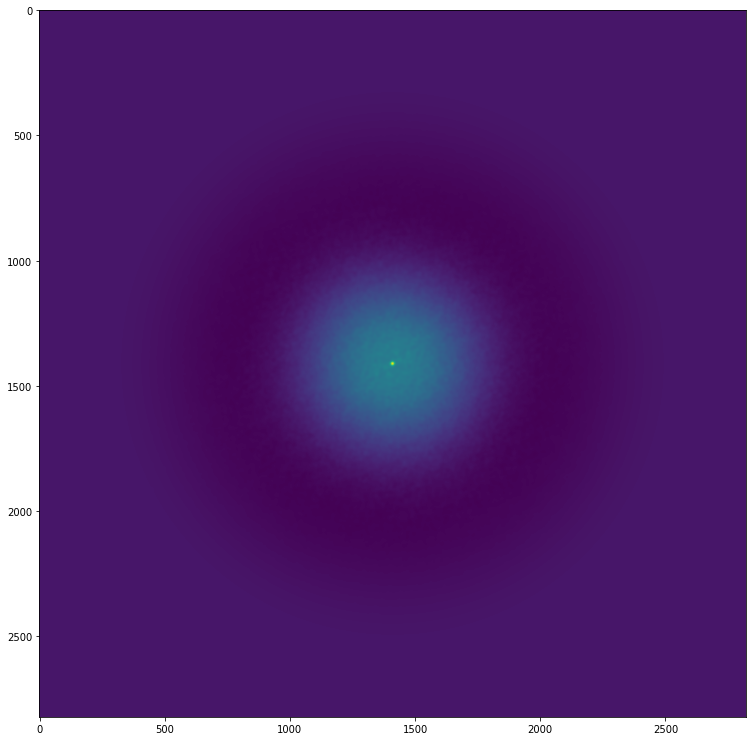

In [415]:
plt.figure(figsize=(13,13))
plt.imshow(corr_real-corr_csr)
plt.savefig("test.jpg")

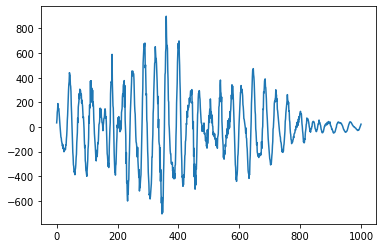

In [394]:
plt.plot(range_of_t, K_ring_diff)

------
## Finding reason for noise

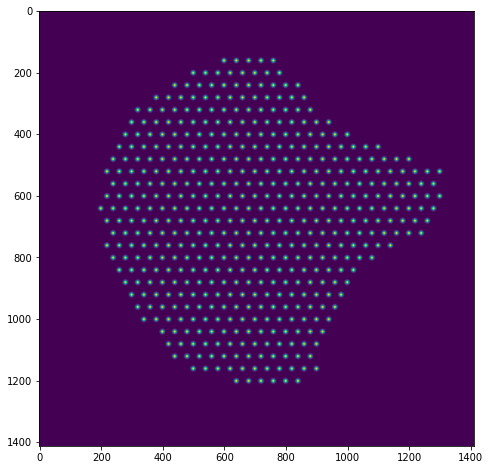

In [373]:
mask = cell#np.ones((1412,1412))
point_radius = 10
spacing = 40
pixel_int = 10
desired_int = 100000000


img_real, img_csr = generate_equally_spaced_image(mask, point_radius, pixel_int, spacing, desired_int)

plt.figure(figsize=(8,8))
plt.imshow(img_real)
plt.show()

In [374]:
real_corr = signal.correlate(img_real, img_real)
csr_corr = signal.correlate(img_csr, img_csr)
diff_corr = real_corr - csr_corr

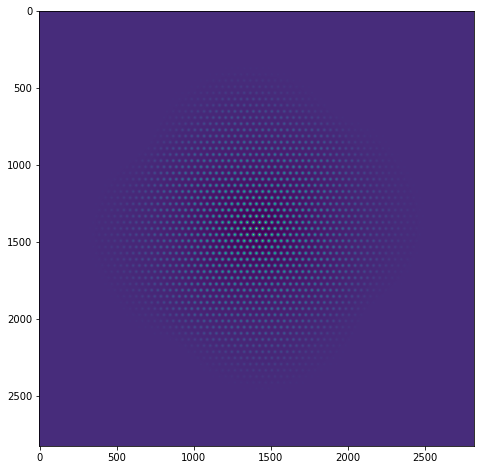

In [375]:
plt.figure(figsize=(8,8))
plt.imshow(diff_corr)
plt.show()

In [376]:
def distance_arr(arr):
    """
    Computes array whose elements are equal to their Euclidean distance from the center.
    """
    dimx, dimy = arr.shape
    # array should have equal dimensions, dimension should be odd
    if (dimx != dimy) or is_even(dimx):
        print("Error! Array has wrong shape!")
        return
        
    half_dim = int((dimx-1)/2)
    x_range = list(range(1,half_dim+1))
    line = x_range[::-1] + [0] + x_range 

    # array where every element is x distance from center
    diff_x = np.array([line, ]*dimx)
        
    # array where every element is y distance from center
    diff_y = diff_x.T
        
    # compute array whose elements are equal to their Euclidean distance from the center
    diff_xy = np.sqrt(diff_x**2 + diff_y**2)
    
    return diff_xy

def cut_circle(arr, radius, diff_xy):
    """
    Takes a 2D array and sets all elements outside a circle (around center of image) with specified radius to zero. 
    """
    mask = np.ones(arr.shape)
    mask[diff_xy>=radius] = 0
    return arr * mask
        

0.0
100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0


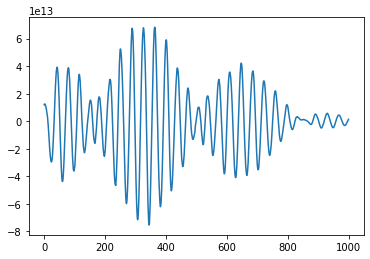

In [382]:
test = diff_corr #np.ones((201,201))
dist = distance_arr(test)

vals = []
for t in np.linspace(0,1000, 1001):
    if t%100==0:
        print(t)
    test_cut = cut_circle(test, t+10, dist) - cut_circle(test, t-10, dist)
    vals.append(np.sum(test_cut))
    
plt.plot(vals)
#plt.figure(figsize=(8,8))
#plt.imshow(test_cut)
#plt.show()


In [389]:
range_of_t = np.linspace(0,1000, 1001)
_, K_real, _ = ripleys_K_fast_ring(img_real, mask, range_of_t, width=20, printout=True)
_, K_csr, _ = ripleys_K_fast_ring(img_csr, mask, range_of_t, width=20, printout=True)
K_diff = np.array(K_real)-np.array(K_csr)

Completed in 126.92 seconds
Completed in 134.34 seconds


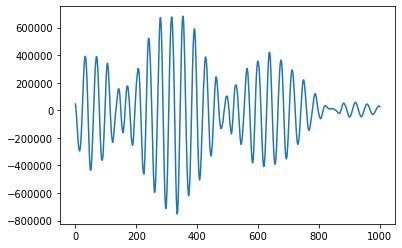

In [390]:
plt.plot(K_diff)

-----


In [8]:
np.sum(K_diff)

4738685.203801382

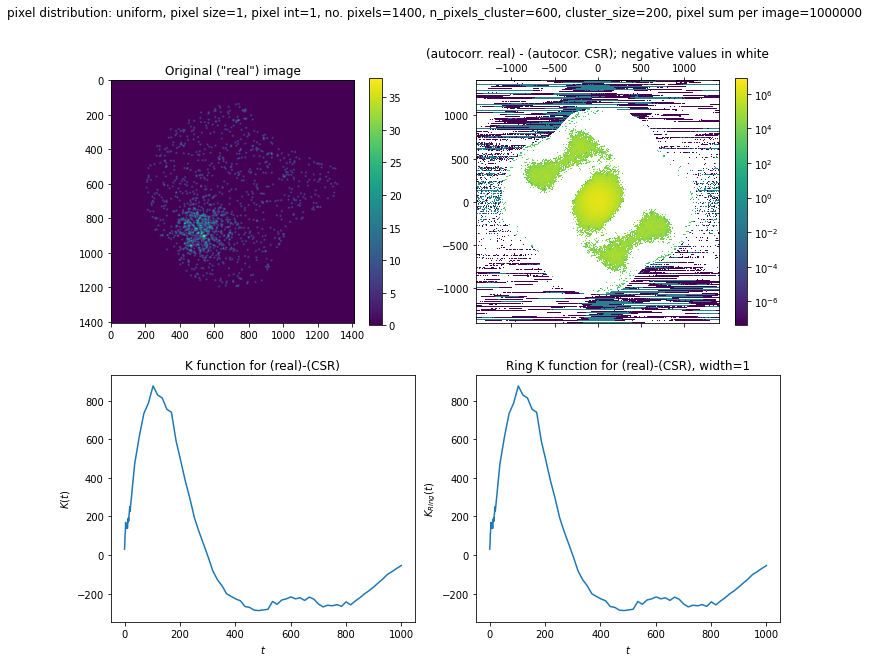

In [88]:

# works only if number odd, should be given for autocorrelation
len_ = corr_real.shape[0]
lim_lower = -int(len_/2)
lim_upper = int(len_/2)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0][0].imshow(img_real)
im1 = ax[0][0].imshow(img_real)
ax[0][0].set_title("Original (\"real\") image")
ax[0][1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
im2 = ax[0][1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper], origin='lower')    
ax[1][0].set_title("Autocorr. real image")

ax[1][0].set_title("K function for (real)-(CSR)")
ax[1][0].plot(range_of_t, K_diff)
ax[1][0].set_xlabel("$t$")
ax[1][0].set_ylabel("$K(t)$")

ax[1][1].set_title(f"Ring K function for (real)-(CSR), width={width}")
ax[1][1].plot(range_of_t, K_diff)
ax[1][1].set_xlabel("$t$")
ax[1][1].set_ylabel("$K_{Ring}(t)$")

plt.colorbar(im1, ax=ax[0, 0])
plt.colorbar(im2, ax=ax[0, 1])

fig.suptitle(title)
plt.show()

In [355]:
wrong = ax[1][0].get_yticks()

ax[1][0].set_yticks([0, 3, 0, 500, 1000, 2000, 2500, 3000])

print(ax[1][0].get_yticks())

[   0    3    0  500 1000 2000 2500 3000]


In [327]:
np.min(corr_real-corr_csr)

-329566.75

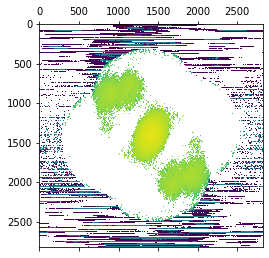

In [312]:
from pylab import figure, cm
from matplotlib.colors import LogNorm
#plt.imshow(corr_real-corr_csr)


plt.matshow(corr_real-corr_csr, norm=LogNorm())
#plt.yticks(auto_corr_ticks)
plt.show()

In [299]:
auto_corr_ticks_wrong = list(range(0, y))
auto_corr_ticks = list(range(-int(y/2),0))+[0]+list(range(0,int(y/2)))

In [300]:
len(auto_corr_ticks_wrong)

2823

In [280]:
vmin = np.min(corr_real)
vmax = np.max(corr_real)
print(vmin, vmax)

vmin = np.min(corr_csr)
vmax = np.max(corr_csr)
print(vmin, vmax)

-0.6320988 8803131.0
-0.22123456 1274734.6


In [261]:
for i in range(9):
    
    n_total = 4000 - 400*i
    n_points = int(n_total * 0.7)
    n_points_cluster = int(n_total * 0.3)
    
    print(n_points_cluster/n_points)

0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42879019908116384
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855


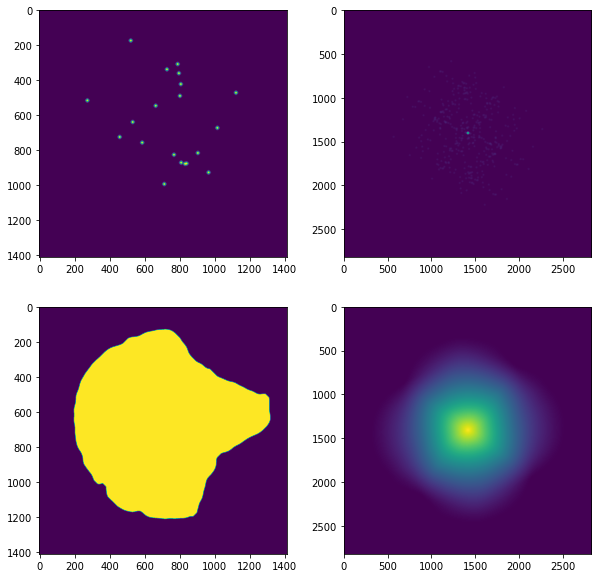

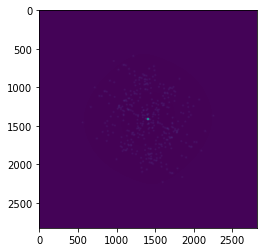

In [24]:
point_radius=1
pixel_int=1
n_points=2000
n_points_cluster=700
cluster_size=200
cluster_pos=(0,0)
desired_int=1000000
binary=False

arr1, mask1 = generate_cell_image_uniform(mask, point_radius, pixel_int, n_points, desired_int, binary)

arr1 = scale_image(arr1, desired_int)
mask1 = scale_image(mask1, desired_int)

auto_corr1 = signal.correlate(arr1.astype('float32'), arr1.astype('float32'), method='fft')
auto_corr_mask1 = signal.correlate(mask1.astype('float32'), mask1.astype('float32'), method='fft')

#arr2, _ = generate_cell_image_uniform(mask, point_radius, pixel_int, n_points, desired_int, binary)
#auto_corr2 = signal.correlate(arr2.astype('float32'), arr2.astype('float32'), method='fft')


fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0][0].imshow(arr1)
ax[0][1].imshow(auto_corr1)
ax[1][0].imshow(mask1)
ax[1][1].imshow(auto_corr_mask1)
plt.show()

plt.imshow(auto_corr1-auto_corr_mask1)
plt.show()

For more randomness, the autocorrelation is more uniform in all directions...

Last image is what we sum over!
Observation(???): middle point is so high, that if the points are not that far apart, K_diff function keeps on rising.
Could we perhaps scale every product by the square of the average intensity? To get rid of the squared stuff or smth.

Is there a better metric to compare the autocorrelations than simply the K function plot?

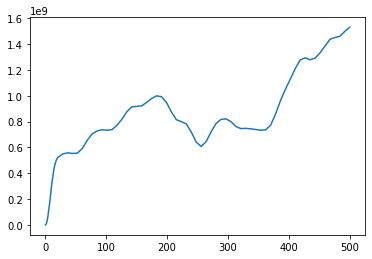

In [27]:
# array whose elements are equal to their Euclidean distance from the center
diff_xy = distance_arr(auto_corr1)

range_of_t = list(range(20)) + list(np.linspace(20, 500, 60))

K_cell = []
K_mask = []

for t in range_of_t:
    # array containing the auto-correlation up to distance t
    auto_corr_t = cut_circle(auto_corr1, radius=t, diff_xy=diff_xy)
    auto_corr_mask_t = cut_circle(auto_corr_mask1, radius=t, diff_xy=diff_xy)
    
    K_cell.append(np.sum(auto_corr_t))
    K_mask.append(np.sum(auto_corr_mask_t))
    
#plt.plot(range_of_t, K_cell)
#plt.plot(range_of_t, K_mask)
plt.plot(range_of_t, np.array(K_cell)-np.array(K_mask))
plt.show()

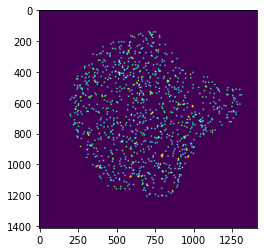

In [53]:
point_radius=1 
pixel_int=10 
n_points=1000

img_real, img_csr = generate_cell_image_uniform(mask, point_radius, pixel_int, n_points)


plt.imshow(exposure.equalize_hist(img_real)>0.97)
plt.show()

In [66]:
np.mean(full_auto1)

1254.8099

In [47]:
exposure.equalize_hist(img_real)>0.9

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
def generate_cell_image_uniform(mask, point_radius=1, pixel_int=10, n_points=1000, desired_int=2000000000, binary=False):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_points:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1:
            arr[rnd_x, rnd_y] = pixel_int
            count+=1

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=point_radius)
    arr = gaussian(arr, sigma=3)
    
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97
        
    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    return img_real, img_csr

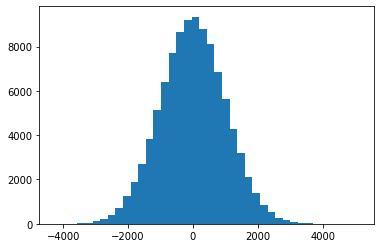

In [88]:
gauss_cont = np.random.normal(0, 1000, 100000)
gauss_trunc = np.round(gauss_cont)
plt.hist(gauss_trunc, bins=40)
plt.show()

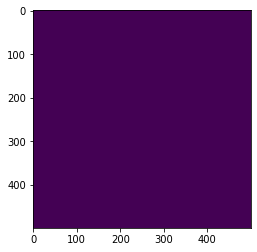

In [74]:
base = np.zeros((500,500))
plt.imshow(base)
plt.show()

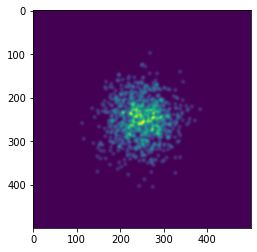

In [105]:



cluster_pos = (0,0)
n_points_cluster = 1000
pixel_int = 10
cluster_size = 100
point_radius = 1


arr = np.zeros((500,500))

x_dim, y_dim = arr.shape

mean_x, mean_y = cluster_pos

# size of cluster := FWHM = 2.355 * sigma (for Gaussian)
sigma = cluster_size/2.355


for i in range(n_points_cluster):
    
    rnd_x = int(truncated_gaussian(mean_x+x_dim/2, sigma))
    rnd_y = int(truncated_gaussian(mean_y+y_dim/2, sigma))
    
    if rnd_x < x_dim and rnd_y < y_dim:
    #print(rnd_x)
        arr[rnd_x, rnd_y] = pixel_int

    
# slightly dilate and blur the pixels to enlarge them
arr = binary_dilation(arr, iterations=point_radius)
arr = gaussian(arr, sigma=3)

plt.imshow(arr)
plt.show()

------

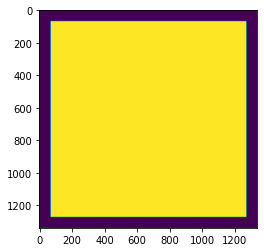

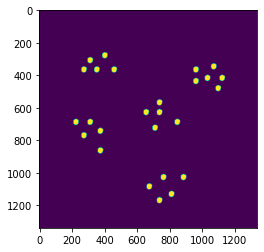

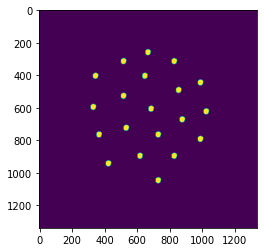

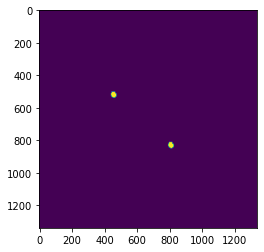

In [ ]:




plt.imshow(mask_csr)
plt.show()
plt.imshow(cluster)
plt.show()
plt.imshow(disp)
plt.show()
plt.imshow(two_dots)
plt.savefig("two_dots.pdf")
plt.show()

In [ ]:
np.sum(disp), np.sum(mask_csr), np.sum(cluster)

(1000.0000000000001, 1000.0000000000003, 1000.0000000000003)

In [9]:
np.sum(masks["square"])

1285956

In [11]:
import cv2 
mask_csr = cv2.imread("toy_data_imgs/csr.png")
mask_csr = cv2.cvtColor(mask_csr, cv2.COLOR_BGR2GRAY)
mask_csr[mask_csr<50] = 1
mask_csr[mask_csr>50] = 0
#mask_csr = scale_image(mask_csr, 1000000)

two_dots = cv2.imread("toy_data_imgs/two_dots.png")
two_dots = cv2.cvtColor(two_dots, cv2.COLOR_BGR2GRAY)
two_dots[two_dots<50] = 1
two_dots[two_dots>50] = 0
#two_dots = scale_image(two_dots, 1000000)

disp = cv2.imread("toy_data_imgs/disperse.png")
disp = cv2.cvtColor(disp, cv2.COLOR_BGR2GRAY)
disp[disp<=230] = 1
disp[disp>230] = 0
#disp = scale_image(disp, 1000000)

cluster = cv2.imread("toy_data_imgs/cluster.png")
cluster = cv2.cvtColor(cluster, cv2.COLOR_BGR2GRAY)
cluster[cluster<=230] = 1
cluster[cluster>230] = 0
#cluster = scale_image(cluster, 1000000)

In [12]:
np.save("toy_data_imgs/two_dots.npy", two_dots)
np.save("toy_data_imgs/dispersed.npy", disp)
np.save("toy_data_imgs/clustered.npy", cluster)


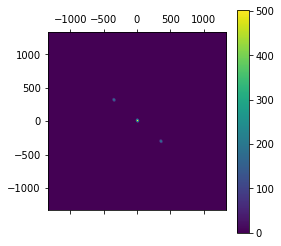

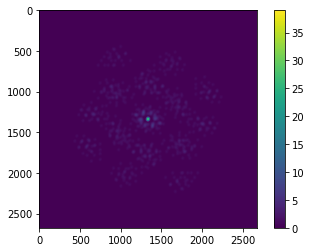

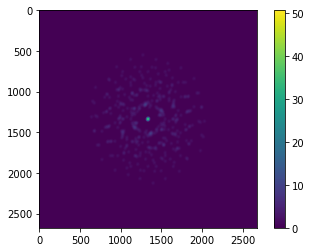

In [404]:
corr_disp = signal.correlate(disp, disp, method='fft') 
corr_cluster = signal.correlate(cluster, cluster, method='fft')
corr_csr = signal.correlate(mask_csr, mask_csr, method='fft')
corr_two_dots = signal.correlate(two_dots, two_dots, method='fft')



len_ = corr_two_dots.shape[0]
lim_lower = -int(len_/2)
lim_upper = int(len_/2)
plt.matshow(corr_two_dots, extent=[lim_lower, lim_upper, lim_lower, lim_upper])    
plt.colorbar()
plt.savefig("two_dots_corr.pdf")
plt.show()
plt.imshow(corr_cluster)#-corr_csr)
plt.colorbar()
plt.show()
plt.imshow(corr_disp)#-corr_csr)
plt.colorbar()
plt.show()

In [206]:




#square = scale_image(square, int_)

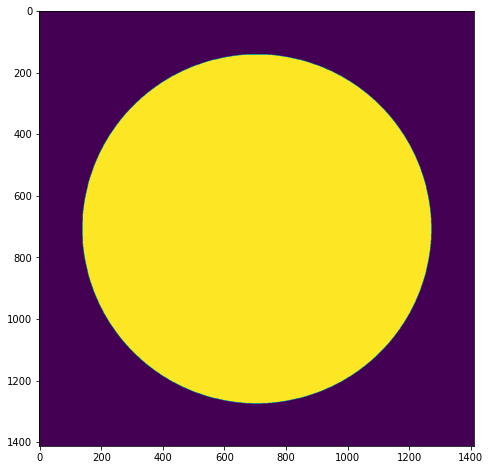

In [203]:
plt.figure(figsize=(8,8))
plt.imshow(circle)

(array([ 707788.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1285956.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

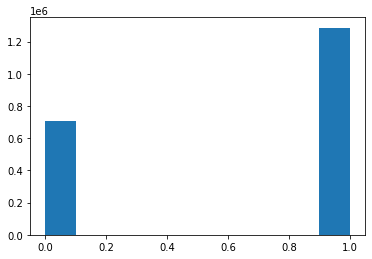

In [195]:
plt.hist(square.ravel())

In [196]:
np.unique(triangle)

array([False,  True])

In [197]:
triangle[1100, 400]

False

In [198]:
np.unique(square)

array([0, 1], dtype=uint8)

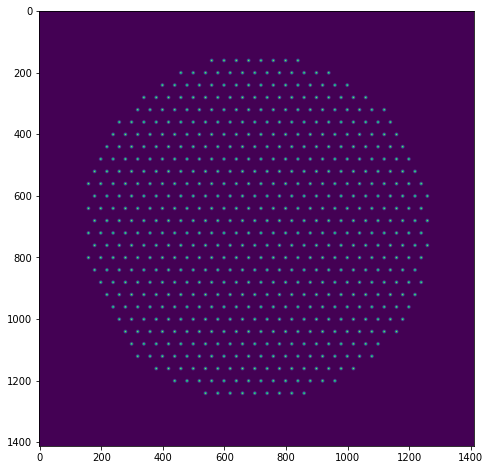

In [256]:
from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes


def generate_equally_spaced_image(mask, spacing, point_radius, pixel_int, n_points, desired_int):
    """
    Within a shape specified by mask, generate equally spaced grid.
    """
    arr = np.zeros(mask.shape)

    spacing = 40

    for i in range(1, int(arr.shape[0]/spacing)):
        for j in range(1, int(arr.shape[1]/spacing)):
            x = i*spacing
            y = j*spacing + int(spacing/2 * (i%2))

            if mask[x,y] == 1:
                arr[x,y] = 10

    arr = binary_dilation(arr, iterations=point_radius-4)
    arr = gaussian(arr, sigma=2)
    
    img_real = scale_image(arr, desired_int)
    img_csr = scale_image(mask, desired_int)

    return img_real, img_csr

spacing = 40
point_radius = 5
arr = generate_equally_spaced_grid(circle)   
plt.figure(figsize=(8,8))
plt.imshow(arr)
plt.savefig("toy_data_imgs/grid.png")
plt.show()

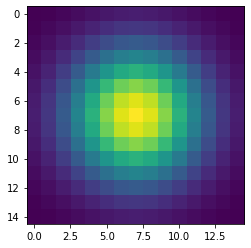

In [230]:
test = np.zeros((15,15))
test[7,7] = 10
point_radius = 6
test = binary_dilation(test, iterations=point_radius-4)
test = gaussian(test, sigma=3)
plt.imshow(test)

In [227]:
binary_dilation

<function scipy.ndimage.morphology.binary_dilation(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)>